# 1 Load the libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O


# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")


# plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Sklearn libraries
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

# 2 Download stock data

In [2]:
def get_stock_data(stock_name):
    
    # For time stamps
    from datetime import datetime
    import yfinance as yf
    
    # The tech stocks we'll use for this analysis
    tech_list = [stock_name]

    dict_of_stocks = {}

    end = datetime.now()
    start = datetime(end.year - 16, end.month, end.day)

    for stock in tech_list:
        globals()[stock] = yf.download(stock, start, end)
        dict_of_stocks[tech_list[0]] = globals()[stock]
        

    return dict_of_stocks[tech_list[0]]

# 3 Inspecting the data

In [3]:
main_df = get_stock_data("KRI.AT")

# main_df = get_stock_data("AAPL")

[*********************100%***********************]  1 of 1 completed


In [4]:
main_df.head(), main_df.tail()

(                Open      High       Low     Close  Adj Close  Volume
 Date                                                                 
 2008-07-04  1.411764  1.411764  1.341176  1.397646   0.998334    7437
 2008-07-07  1.411764  1.411764  1.376470  1.376470   0.983208     425
 2008-07-08  1.362352  1.376470  1.341176  1.376470   0.983208    8358
 2008-07-09  1.390587  1.390587  1.355293  1.376470   0.983208    8818
 2008-07-10  1.348234  1.376470  1.348234  1.376470   0.983208    4342,
              Open   High    Low  Close  Adj Close  Volume
 Date                                                     
 2024-06-28  11.05  11.40  11.05  11.35      11.35    7782
 2024-07-01  11.35  11.45  11.10  11.45      11.45    5635
 2024-07-02  11.50  11.50  11.20  11.25      11.25    2793
 2024-07-03  11.25  11.50  11.25  11.45      11.45    4194
 2024-07-04  11.50  11.55  11.50  11.55      11.55    1802)

# 4-2 Dataset timestamps

In [5]:
#Experiment_1

# KRI.AT
train_start_time = '2020-01-01'
train_end_time = '2024-03-31'

validation_start_time = '2024-04-01'
validation_end_time = '2024-04-30'

test_start_time = '2024-05-01'
test_end_time = '2024-05-31'
#test_end_time = str(main_df.index[-1].year)+"-"+str(main_df.index[-1].month)+"-"+str(main_df.index[-1].day)


# ΝΚΕ
#train_start_time = '2009-04-06'
#train_end_time = '2017-03-02'

#validation_start_time = '2017-03-03'
#validation_end_time = '2017-03-04'

#test_start_time = '2017-03-04'
#test_end_time = '2019-05-04'
#test_end_time = str(main_df.index[-1].year)+"-"+str(main_df.index[-1].month)+"-"+str(main_df.index[-1].day)

# dataframe with performances

In [6]:
df_performances = pd.DataFrame(index=['rmse', 'mape'])
df_performances

""
rmse
mape


# 5 Statistical Learning - Time Series

# Arima

Here I have a method that creates the train, validation and test set.

In [7]:
# 5 Statistical Learning - Time Series

def split_dataset_for_arima(main_df, 
                            train_start = '2020-01-01',
                            train_end = '2024-03-31', 
                            validation_start = '2024-04-01',
                            validation_end = '2024-04-30',
                            test_start = '2024-05-01',
                            test_end = '2023-05-30',
                            with_fe = False):
    

    # if feature engineering:
    if with_fe:
        main_df = financial_indicators(main_df.copy())


    # Split the data into train, validation, and test sets
    train_set = main_df[(main_df.index >= train_start) & (main_df.index <= train_end)]
    validation_set = main_df[(main_df.index >= validation_start) & (main_df.index <= validation_end)]
    train_and_validation_set = pd.concat([train_set, validation_set], axis=0)
    test_set = main_df[(main_df.index >= test_start) & (main_df.index <= test_end)]


    # Print the sizes of the sets
    print("Train Set Size:", len(train_set))
    print("Validation Set Size:", len(validation_set))
    print("Test Set Size:", len(test_set))


    print(test_set.tail(10))

    return train_set, validation_set, train_and_validation_set, test_set

In [8]:
train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_arima(main_df.copy(), 
                                    train_start = train_start_time,
                                    train_end = train_end_time, 
                                    validation_start = validation_start_time,
                                    validation_end = validation_end_time,
                                    test_start = test_start_time,
                                    test_end = test_end_time,
                                    with_fe=False)

Train Set Size: 1056
Validation Set Size: 21
Test Set Size: 19
             Open   High    Low  Close  Adj Close  Volume
Date                                                     
2024-05-20  11.05  11.10  10.95  11.05      11.05   13571
2024-05-21  11.10  11.10  10.90  11.05      11.05   11716
2024-05-22  11.15  11.25  10.90  11.15      11.15   15509
2024-05-23  11.10  11.30  11.05  11.30      11.30    7593
2024-05-24  11.30  11.30  11.15  11.30      11.30    3728
2024-05-27  11.30  11.40  10.95  10.95      10.95    9785
2024-05-28  11.20  11.20  10.95  11.20      11.20    9842
2024-05-29  11.20  11.25  10.95  11.00      11.00    5256
2024-05-30  11.20  11.20  10.90  11.20      11.20   12533
2024-05-31  11.25  11.40  11.05  11.15      11.15   29666


In [9]:
def auto_arima(df):

     import pmdarima as pm

     auto_arima_model = pm.auto_arima(train_and_validation_set['Close'], start_p=1, d=None, start_q=1, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False,error_action='ignore',  
                              suppress_warnings=True,
                         stepwise=True, trace=True)
     
     return auto_arima_model

auto_arima_model = auto_arima(train_and_validation_set)

          

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1406.131, Time=1.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1399.156, Time=0.50 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1405.975, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1405.496, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1399.636, Time=0.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1404.137, Time=1.96 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1404.138, Time=2.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1404.291, Time=0.93 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1404.970, Time=0.52 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1402.842, Time=3.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1406.410, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1405.663, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1406.154, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1404.425, Time=0.91 sec
 ARIMA(1,1,2)(0,0,0

c:\Users\praxitelis\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\praxitelis\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\praxitelis\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                   8.888
Date:                Thu, 04 Jul 2024   AIC                            -11.777
Time:                        12:46:50   BIC                             -8.944
Sample:                             0   HQIC                           -11.297
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9973      0.127     -7.859      0.000      -1.246      -0.749
ma.L1          0.9620      0.880      1.093      0.274      -0.763       2.687
sigma2         0.0216      0.019      1.110      0.2

<Figure size 640x480 with 0 Axes>

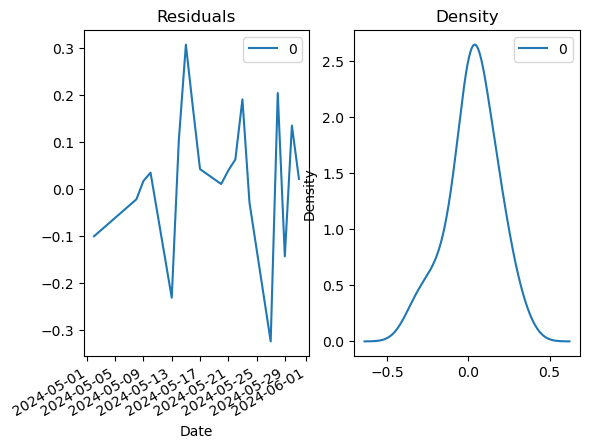

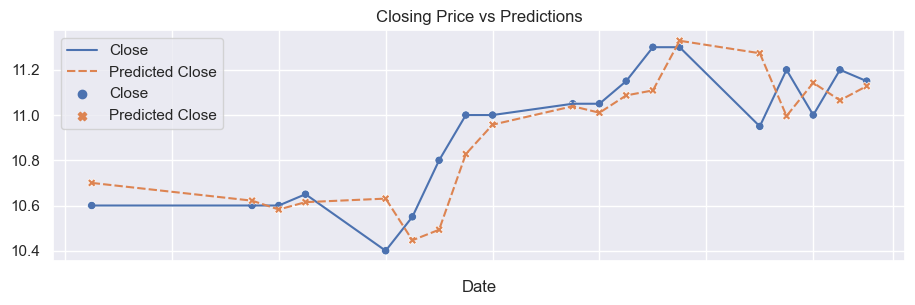

In [10]:
def build_arima_model(auto_arima_model, test_set):

    from statsmodels.tsa.arima.model import ARIMA

    # Fit the ARIMA model into the test set
    if auto_arima_model.order[0] > 0:
        df = pd.concat([validation_set[-auto_arima_model.order[0]:], test_set])
    else:
        df = pd.concat([validation_set[-1:], test_set])

    arima_model = ARIMA(df['Close'], order=(auto_arima_model.order[0], 
                                            auto_arima_model.order[1], 
                                            auto_arima_model.order[2]))




    arima_model_res = arima_model.fit()
    print(arima_model_res.summary())

    # create forecasts
    if auto_arima_model.order[0] > 0:
        forecasts =  arima_model_res.predict(start=auto_arima_model.order[0], end=len(df)-1)
    else:
        forecasts =  arima_model_res.predict(start=1, n_periods=len(test_set)-1)

    print(len(forecasts), forecasts[0])

    # evaluate forecasts against test_set
    from sklearn.metrics import mean_squared_error

    mse = mean_squared_error(test_set['Close'], forecasts)
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Calculate MAPE (Mean Absolute Percentage Error) to evaluate the model's performance
    mape = mean_absolute_percentage_error(test_set['Close'], forecasts)
    print(f"MAPE: {mape}")

    # Plot residual errors
    residuals = pd.DataFrame(arima_model_res.resid)[1:]
    
    plt.figure()
    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_set.index,
                       'Close': test_set['Close'],
                        'Predicted Close': forecasts
                            })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')

    return arima_model, rmse, mape

arima_model, arima_rmse, arima_mape = build_arima_model(auto_arima_model, test_set)

df_performances['Arima'] = [arima_rmse,arima_mape]

# Prepare for machine learning

In [11]:
def split_dataset_for_ml(main_df,
                        train_start = '2020-01-01',
                        train_end = '2022-12-31', 
                        validation_start = '2023-01-01',
                        validation_end = '2023-08-31',
                        test_start = '2023-09-01',
                        test_end = '2023-09-30',
                        best_lag_period = 0,
                        with_fe = False,
                        is_diffed = False):
    
    #####
    def get_datasets_after_finding_best_lags(main_df, columns, best_lag_period):

        for lag_period in range(1, best_lag_period+1):
        # Create lag features
            for feature in columns:
                main_df['{}_Lag_{}'.format(feature, lag_period)] = main_df[feature].shift(lag_period)

                # fill NaN values
                main_df.dropna(inplace=True)

        return main_df
    #####
    
    # get initial columns from main_df
    columns = main_df.copy().columns

    if best_lag_period>0:
        main_df = get_datasets_after_finding_best_lags(main_df.copy(), columns = columns, 
                                                       best_lag_period = best_lag_period)

    ### prepare for feature engineering
    if with_fe:
        main_df = financial_indicators(main_df.copy())
    
    # Prepare the closing price as target variable    
    main_df['target'] = main_df['Close'].shift(-1)

    if is_diffed == True:
        for col in columns:
            main_df[col] = main_df[col].diff(1).dropna()
        main_df['target'] = main_df['target'].diff(1).dropna()


    # Split the data into train, validation, and test sets
    train_set = main_df[(main_df.index >= train_start) & (main_df.index <= train_end)]
    validation_set = main_df[(main_df.index >= validation_start) & (main_df.index <= validation_end)]
    train_and_validation_set = pd.concat([train_set, validation_set], axis=0)

    test_set = main_df[(main_df.index >= test_start) & (main_df.index <= test_end)]
    test_set = test_set[:-1]    


    return train_set, validation_set, train_and_validation_set, test_set

# Run 1

default models, default features

## Random Forest

In [12]:
def build_random_forest_default_model(main_df, with_fe=False):

    from sklearn.ensemble import RandomForestRegressor
    
    train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml(main_df.copy(), 
                                train_start = train_start_time,
                                train_end = train_end_time,
                                validation_start = validation_start_time,
                                validation_end = validation_end_time,
                                test_start = test_start_time,
                                test_end = test_end_time,
                                best_lag_period = 0,
                                with_fe = with_fe,
                                is_diffed = False)


    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_and_validation_set)
    train_data = pd.DataFrame(scaled_array, columns=train_and_validation_set.columns, index=train_and_validation_set.index)
    
    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)

    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']
    
    
    # Train the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=4)
    model.fit(X_train, y_train)

    # Make predictions using the trained model
    y_pred = model.predict(X_test)


    
    train_data = train_and_validation_set.copy()
    test_data = test_set.copy()
    y_pred = (y_pred * train_data['target'].std()) + train_data['target'].mean()
    
    test_data["y_pred"] = y_pred

    
    
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")

    # Calculate MAPE (Mean Absolute Percentage Error) to evaluate the model's performance
    mape = mean_absolute_percentage_error(test_data["target"], test_data["y_pred"])
    print(f"MAPE: {mape}")


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                       'Close': test_data['target'],
                       'Predicted Close': test_data['y_pred']
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')
    
    
    return model, rmse, mape

RMSE: 0.1336723055110057
MAPE: 0.009768123965087225


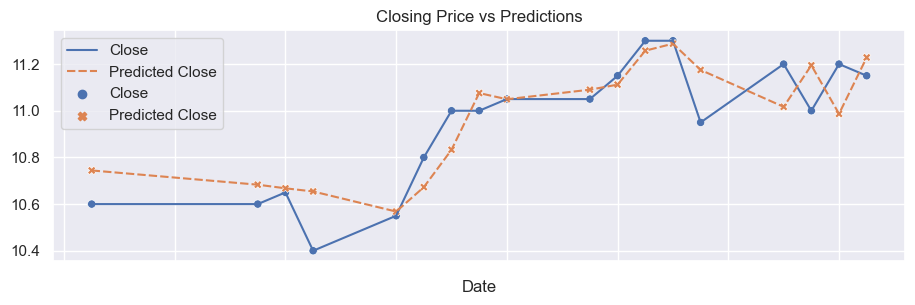

In [13]:
# Random Forest default model with default features
rf_model, rf_model_rmse, rf_model_mape = build_random_forest_default_model(main_df.copy(), 
                                                                    with_fe = False)

# Save the model performance
df_performances['rf'] = [rf_model_rmse, rf_model_mape]

## XGBoost

In [14]:
def build_xgboost_default_model(main_df, with_fe=False):
    
    import xgboost as xgb
    
    train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml(main_df.copy(), 
                                train_start = train_start_time,
                                train_end = train_end_time,
                                validation_start = validation_start_time,
                                validation_end = validation_end_time,
                                test_start = test_start_time,
                                test_end = test_end_time,
                                best_lag_period = 0,
                                with_fe = with_fe,
                                is_diffed = False)

    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_and_validation_set)
    train_data = pd.DataFrame(scaled_array, columns=train_and_validation_set.columns, index=train_and_validation_set.index)
    
    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)
    
    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']
    
    
    # Train the Random Forest model
    model = xgb.XGBRegressor(n_estimators=100, seed=42)
    model.fit(X_train, y_train)

    # Make predictions using the trained model
    y_pred = model.predict(X_test)


    train_data = train_and_validation_set.copy()
    test_data = test_set.copy()
    y_pred = (y_pred * train_data['target'].std()) + train_data['target'].mean()
    
    test_data["y_pred"] = y_pred
    
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")

    # Calculate MAPE (Mean Absolute Percentage Error) to evaluate the model's performance
    mape = mean_absolute_percentage_error(test_data["target"], test_data["y_pred"])
    print(f"MAPE: {mape}")


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                       'Close': test_data['target'],
                       'Predicted Close': test_data['y_pred']
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')
    
    
    return model, rmse, mape

RMSE: 0.2004654576596926
MAPE: 0.014438233422891291


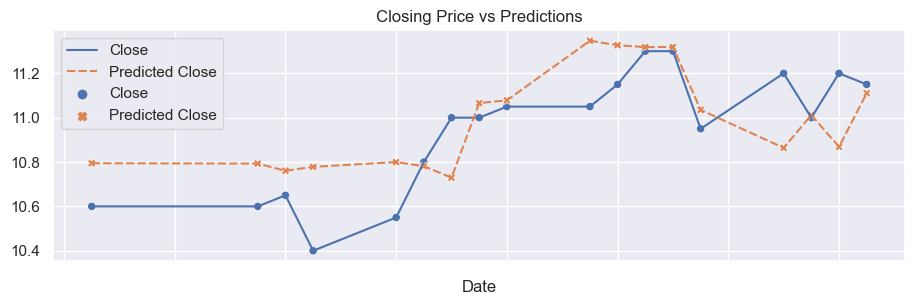

In [15]:
# build XGB model with lagged values and default parameters
xgb_model, xgb_model_rmse, xgb_model_mape = build_xgboost_default_model(main_df.copy(), with_fe=False)


# Save the model performance
df_performances['xgb'] = [xgb_model_rmse, xgb_model_mape]

## SVM

In [16]:
def build_svm_default_model(main_df, with_fe=False):
    
    from sklearn.svm import SVR
    
    train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml(main_df.copy(), 
                                train_start = train_start_time,
                                train_end = train_end_time,
                                validation_start = validation_start_time,
                                validation_end = validation_end_time,
                                test_start = test_start_time,
                                test_end = test_end_time,
                                best_lag_period = 0,
                                with_fe = with_fe,
                                is_diffed = False)

    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_and_validation_set)
    train_data = pd.DataFrame(scaled_array, columns=train_and_validation_set.columns, index=train_and_validation_set.index)
    
    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)
    
    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']
    
    
    
    # Train the Random Forest model
    model = SVR(kernel='rbf')
    model.fit(X_train, y_train)

    # Make predictions using the trained model
    y_pred = model.predict(X_test)


    test_data["y_pred"] = y_pred


    train_data = train_and_validation_set.copy()
    test_data = test_set.copy()
    y_pred = (y_pred * train_data['target'].std()) + train_data['target'].mean()
    
    test_data["y_pred"] = y_pred
    
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")

    # Calculate MAPE (Mean Absolute Percentage Error) to evaluate the model's performance
    mape = mean_absolute_percentage_error(test_data["target"], test_data["y_pred"])
    print(f"MAPE: {mape}")


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                       'Close': test_data['target'],
                       'Predicted Close': test_data['y_pred']
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')
    
    
    return model, rmse, mape

RMSE: 0.1445651040443465
MAPE: 0.010755104992716457


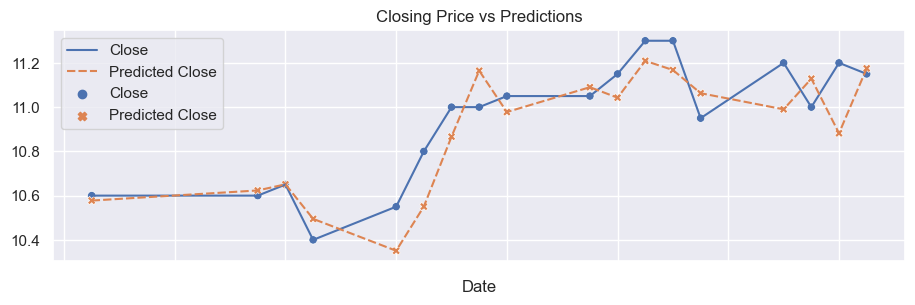

In [17]:
# build XGB model with lagged values and default parameters
svm_model, svm_model_rmse, svm_model_mape = build_svm_default_model(main_df.copy(), with_fe=False)


# Save the model performance
df_performances['svm'] = [svm_model_rmse, svm_model_mape]

## kNN

In [18]:
def build_knn_default_model(main_df, with_fe = False):
    
    from sklearn.neighbors import KNeighborsRegressor

    train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml(main_df.copy(), 
                                train_start = train_start_time,
                                train_end = train_end_time,
                                validation_start = validation_start_time,
                                validation_end = validation_end_time,
                                test_start = test_start_time,
                                test_end = test_end_time,
                                best_lag_period = 0,
                                with_fe = with_fe,
                                is_diffed = False)

    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_and_validation_set)
    train_data = pd.DataFrame(scaled_array, columns=train_and_validation_set.columns, index=train_and_validation_set.index)
    
    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)
    
    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']
    
    
    
    # Train the Random Forest model
    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(X_train, y_train)

    # Make predictions using the trained model
    y_pred = model.predict(X_test)


    train_data = train_and_validation_set.copy()
    test_data = test_set.copy()
    y_pred = (y_pred * train_data['target'].std()) + train_data['target'].mean()
    
    test_data["y_pred"] = y_pred
    
    
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")


    # Calculate MAPE (Mean Absolute Percentage Error) to evaluate the model's performance
    mape = mean_absolute_percentage_error(test_data["target"], test_data["y_pred"])
    print(f"MAPE: {mape}")


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                       'Close': test_data['target'],
                       'Predicted Close': test_data['y_pred']
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')
    
    
    return model, rmse, mape

RMSE: 0.18103266923694616
MAPE: 0.014192059407129053


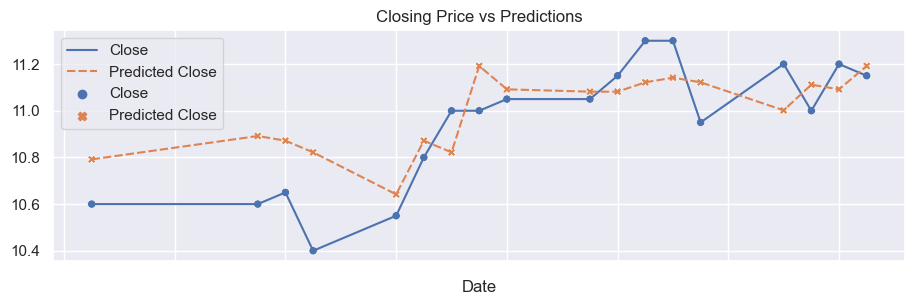

In [19]:
knn_model, knn_model_rmse, knn_model_mape = build_knn_default_model(main_df.copy(), with_fe=False)

# # Save the model performance
df_performances['knn'] = [knn_model_rmse, knn_model_mape]

## LSTM

In [20]:
def build_lstm_default_model(main_df, with_fe=False):
    
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    from sklearn.metrics import mean_squared_error
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Set a random seed
    np.random.seed(42)

    train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml(main_df.copy(), 
                            train_start = train_start_time,
                            train_end = train_end_time,
                            validation_start = validation_start_time,
                            validation_end = validation_end_time,
                            test_start = test_start_time,
                            test_end = test_end_time,
                            best_lag_period = 0,
                            is_diffed = False,
                            with_fe = with_fe)
    
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_and_validation_set)
    train_data = pd.DataFrame(scaled_array, columns=train_and_validation_set.columns, index=train_and_validation_set.index)
    
    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)
    
    # Prepare the data for LSTM
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']
    
    # Reshape input to be 3D [samples, time steps, features]
    X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Train the LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(10, input_shape=(X_train.shape[1], X_train.shape[2])))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')
    lstm_model.fit(X_train, y_train, epochs=10, batch_size=10, verbose=2)
    
    # Make predictions using the trained model
    y_pred = lstm_model.predict(X_test)
    
    # Rescale predictions back to the original scale
    train_data = train_and_validation_set.copy()
    test_data = test_set.copy()
    y_pred = (y_pred * train_data['target'].std()) + train_data['target'].mean()
    
    test_data["y_pred"] = y_pred
    
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")

    # Calculate MAPE (Mean Absolute Percentage Error) to evaluate the model's performance
    mape = mean_absolute_percentage_error(test_data["target"], test_data["y_pred"])
    print(f"MAPE: {mape}")

    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                       'Close': test_data['target'],
                       'Predicted Close': test_data['y_pred']
                       })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')

    return lstm_model, rmse, mape


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1077 samples
Epoch 1/10
1077/1077 - 11s - loss: 0.8085
Epoch 2/10
1077/1077 - 1s - loss: 0.2811
Epoch 3/10
1077/1077 - 1s - loss: 0.0965
Epoch 4/10
1077/1077 - 1s - loss: 0.0509
Epoch 5/10
1077/1077 - 2s - loss: 0.0387
Epoch 6/10
1077/1077 - 1s - loss: 0.0311
Epoch 7/10
1077/1077 - 1s - loss: 0.0258
Epoch 8/10
1077/1077 - 1s - loss: 0.0215
Epoch 9/10
1077/1077 - 2s - loss: 0.0182
Epoch 10/10
1077/1077 - 1s - loss: 0.0157
RMSE: 0.23309400459633486
MAPE: 0.017614264219224445


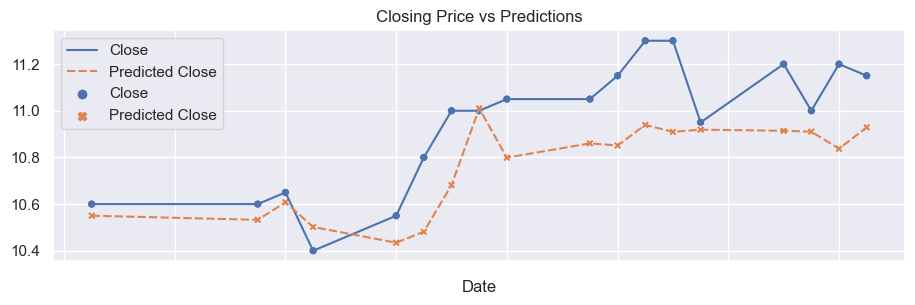

In [21]:
lstm_model, lstm_rmse, lstm_mape = build_lstm_default_model(main_df.copy(), with_fe = False)


df_performances['lstm'] = [lstm_rmse, lstm_mape]

# Run 2

tuned models and default features

## Random Forest

In [22]:
def build_random_forest_grid_search_model(main_df, with_fe = True):

    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import GridSearchCV


    train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml(main_df.copy(), 
                                    train_start = train_start_time,
                                    train_end = train_end_time,
                                    validation_start = validation_start_time,
                                    validation_end = validation_end_time,
                                    test_start = test_start_time,
                                    test_end = test_end_time,
                                    best_lag_period = 0,
                                    with_fe = with_fe,
                                    is_diffed = False)

    train_data = train_and_validation_set.copy()
    test_data = test_set.copy()

    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']


    rf = RandomForestRegressor()
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [10, 20, 30, None]
    }

    rf_grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1, scoring='neg_mean_squared_error')
    rf_grid_search.fit(X_train, y_train)

    best_rf_model = rf_grid_search.best_estimator_
    print(rf_grid_search.best_params_)
    y_pred = best_rf_model.predict(X_test)


    test_data["y_pred"] = y_pred
        
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")


    # Calculate MAPE (Mean Absolute Percentage Error) to evaluate the model's performance
    mape = mean_absolute_percentage_error(test_data["target"], test_data["y_pred"])
    print(f"MAPE: {mape}")


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                        'Close': test_data['target'],
                        'Predicted Close': test_data['y_pred']
                            })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')

    return best_rf_model, rmse, mape

{'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100}
RMSE: 0.14122234481287263
MAPE: 0.010959004471314546


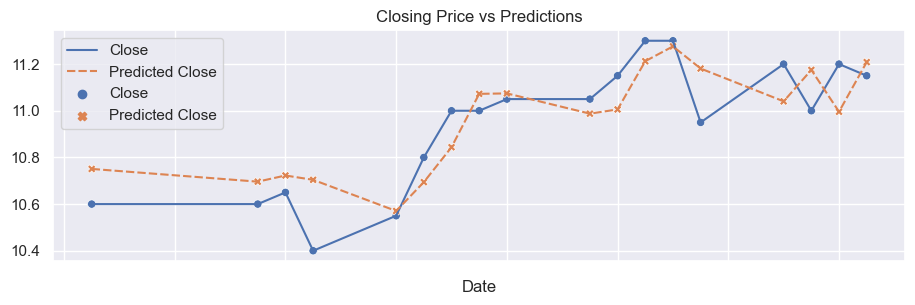

In [23]:
# Random Forest default model with default features
rf_model_grid, rf_model_grid_rmse, rf_model_grid_mape = build_random_forest_grid_search_model(main_df.copy(), 
                                                                    with_fe = False)

# Save the model performance
df_performances['rf_grid'] = [rf_model_grid_rmse, rf_model_grid_mape]

## XGBoost

In [24]:
def build_xgboost_grid_search_model(main_df, with_fe = True):


    from sklearn.model_selection import GridSearchCV


    train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml(main_df.copy(), 
                                    train_start = train_start_time,
                                    train_end = train_end_time,
                                    validation_start = validation_start_time,
                                    validation_end = validation_end_time,
                                    test_start = test_start_time,
                                    test_end = test_end_time,
                                    best_lag_period = 0,
                                    with_fe = with_fe,
                                    is_diffed = False)

    train_data = train_and_validation_set.copy()
    test_data = test_set.copy()

    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']


    from xgboost import XGBRegressor

    xgb = XGBRegressor()
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
        'max_depth': [3, 5, 7, 9]
    }

    xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=2, n_jobs=-1, scoring='neg_mean_squared_error')
    xgb_grid_search.fit(X_train, y_train)

    best_xgb_model = xgb_grid_search.best_estimator_
    print(xgb_grid_search.best_params_)
    y_pred = best_xgb_model.predict(X_test)


    test_data["y_pred"] = y_pred
        
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")

    # Calculate MAPE (Mean Absolute Percentage Error) to evaluate the model's performance
    mape = mean_absolute_percentage_error(test_data["target"], test_data["y_pred"])
    print(f"MAPE: {mape}")


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                        'Close': test_data['target'],
                        'Predicted Close': test_data['y_pred']
                            })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')

    return best_xgb_model, rmse, mape

{'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200}
RMSE: 0.17430941990428717
MAPE: 0.012413281655333787


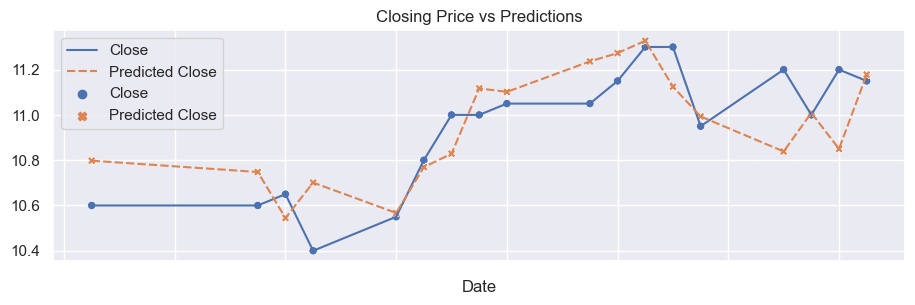

In [25]:
# Random Forest default model with feature engineering
xgb_model_grid, xgb_model_grid_rmse, xgb_model_grid_mape = build_xgboost_grid_search_model(main_df.copy(), 
                                                                    with_fe = False)

# Save the model performance
df_performances['xgb_grid'] = [xgb_model_grid_rmse, xgb_model_grid_mape]

## kNN

In [26]:
def build_knn_grid_search_model(main_df, with_fe = True):

    from sklearn.model_selection import GridSearchCV


    train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml(main_df.copy(), 
                                    train_start = train_start_time,
                                    train_end = train_end_time,
                                    validation_start = validation_start_time,
                                    validation_end = validation_end_time,
                                    test_start = test_start_time,
                                    test_end = test_end_time,
                                    best_lag_period = 0,
                                    with_fe = with_fe,
                                    is_diffed = False)

    train_data = train_and_validation_set.copy()
    test_data = test_set.copy()

    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']


    from sklearn.neighbors import KNeighborsRegressor

    knn = KNeighborsRegressor()
    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    knn_grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=2, n_jobs=-1, scoring='neg_mean_squared_error')
    knn_grid_search.fit(X_train, y_train)

    best_knn_model = knn_grid_search.best_estimator_
    print(knn_grid_search.best_params_)
    y_pred = best_knn_model.predict(X_test)


    test_data["y_pred"] = y_pred
        
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")

    # Calculate MAPE (Mean Absolute Percentage Error) to evaluate the model's performance
    mape = mean_absolute_percentage_error(test_data["target"], test_data["y_pred"])
    print(f"MAPE: {mape}")


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                        'Close': test_data['target'],
                        'Predicted Close': test_data['y_pred']
                            })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')

    return best_knn_model, rmse, mape

RMSE: 0.18103266923694616
MAPE: 0.014192059407129053


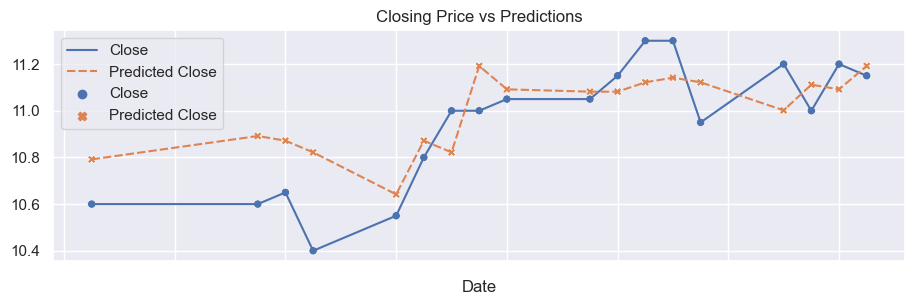

In [27]:
knn_model_grid, knn_model_grid_rmse, knn_model_grid_mape = build_knn_default_model(main_df.copy(), with_fe=False)

# Save the model performance
df_performances['knn_grid'] = [knn_model_grid_rmse, knn_model_grid_mape]

## SVM

In [28]:
def build_svm_grid_search_model(main_df, with_fe = True):


    from sklearn.model_selection import GridSearchCV


    train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml(main_df.copy(), 
                                    train_start = train_start_time,
                                    train_end = train_end_time,
                                    validation_start = validation_start_time,
                                    validation_end = validation_end_time,
                                    test_start = test_start_time,
                                    test_end = test_end_time,
                                    best_lag_period = 0,
                                    with_fe = True,
                                    is_diffed = False)

    train_data = train_and_validation_set.copy()
    test_data = test_set.copy()

    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']


    from sklearn.svm import SVR

    svm = SVR()
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [1e-4, 1e-3, 1e-2, 1e-1],
        'kernel': ['rbf']
    }

    svm_grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=2, n_jobs=-1, scoring='neg_mean_squared_error')
    svm_grid_search.fit(X_train, y_train)

    best_svm_model = svm_grid_search.best_estimator_
    print(svm_grid_search.best_params_)
    y_pred = best_svm_model.predict(X_test)



    test_data["y_pred"] = y_pred
        
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")


    # Calculate MAPE (Mean Absolute Percentage Error) to evaluate the model's performance
    mape = mean_absolute_percentage_error(test_data["target"], test_data["y_pred"])
    print(f"MAPE: {mape}")


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                        'Close': test_data['target'],
                        'Predicted Close': test_data['y_pred']
                            })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')


    return best_svm_model, rmse, mape

RMSE: 0.1445651040443465
MAPE: 0.010755104992716457


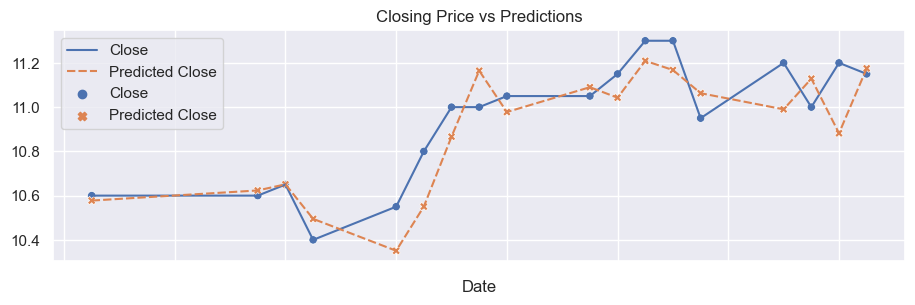

In [29]:
svm_model_grid, svm_model_grid_rmse, svm_model_grid_mape = build_svm_default_model(main_df.copy(), with_fe=False)

# Save the model performance
df_performances['svm_grid'] = [svm_model_grid_rmse, svm_model_grid_mape]

## LSTM

In [30]:
def build_lstm_grid_search_model(main_df, with_fe = True):


    import numpy as np
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
    from sklearn.model_selection import GridSearchCV

    train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml(main_df.copy(), 
                                    train_start = train_start_time,
                                    train_end = train_end_time,
                                    validation_start = validation_start_time,
                                    validation_end = validation_end_time,
                                    test_start = test_start_time,
                                    test_end = test_end_time,
                                    best_lag_period = 0,
                                    with_fe = with_fe,
                                    is_diffed = False)
    

    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_and_validation_set)
    train_data = pd.DataFrame(scaled_array, columns=train_and_validation_set.columns, index=train_and_validation_set.index)
    
    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)

    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']


    # Reshape input to be 3D [samples, time steps, features]
    X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))


    def create_lstm_model(units=10, optimizer='adam'):
        model = Sequential()
        model.add(LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model

    lstm_model = KerasRegressor(build_fn=create_lstm_model, verbose=2)

    param_grid = {
        'units': [10, 20, 30],
        'batch_size': [5, 10, 15],
        'epochs': [10, 15, 20],
        'optimizer': ['adam', 'rmsprop']
    }

    lstm_grid_search = GridSearchCV(estimator=lstm_model, param_grid=param_grid, cv=2, n_jobs=-1)
    lstm_grid_search.fit(X_train, y_train)

    best_lstm_model = lstm_grid_search.best_estimator_
    print(lstm_grid_search.best_params_)
    y_pred = best_lstm_model.predict(X_test)

    # Rescale predictions back to the original scale
    train_data = train_and_validation_set.copy()
    test_data = test_set.copy()
    y_pred = (y_pred * train_data['target'].std()) + train_data['target'].mean()
    
    test_data["y_pred"] = y_pred
        
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")

    # Calculate MAPE (Mean Absolute Percentage Error) to evaluate the model's performance
    mape = mean_absolute_percentage_error(test_data["target"], test_data["y_pred"])
    print(f"MAPE: {mape}")


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                        'Close': test_data['target'],
                        'Predicted Close': test_data['y_pred']
                            })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')


    return best_lstm_model, rmse, mape


Train on 1077 samples
Epoch 1/20
1077/1077 - 5s - loss: 0.6495
Epoch 2/20
1077/1077 - 1s - loss: 0.0960
Epoch 3/20
1077/1077 - 2s - loss: 0.0194
Epoch 4/20
1077/1077 - 1s - loss: 0.0126
Epoch 5/20
1077/1077 - 1s - loss: 0.0090
Epoch 6/20
1077/1077 - 1s - loss: 0.0079
Epoch 7/20
1077/1077 - 1s - loss: 0.0075
Epoch 8/20
1077/1077 - 1s - loss: 0.0074
Epoch 9/20
1077/1077 - 1s - loss: 0.0072
Epoch 10/20
1077/1077 - 1s - loss: 0.0072
Epoch 11/20
1077/1077 - 1s - loss: 0.0073
Epoch 12/20
1077/1077 - 1s - loss: 0.0070
Epoch 13/20
1077/1077 - 1s - loss: 0.0070
Epoch 14/20
1077/1077 - 1s - loss: 0.0072
Epoch 15/20
1077/1077 - 1s - loss: 0.0070
Epoch 16/20
1077/1077 - 2s - loss: 0.0071
Epoch 17/20
1077/1077 - 1s - loss: 0.0069
Epoch 18/20
1077/1077 - 3s - loss: 0.0069
Epoch 19/20
1077/1077 - 1s - loss: 0.0067
Epoch 20/20
1077/1077 - 2s - loss: 0.0068
{'batch_size': 15, 'epochs': 20, 'optimizer': 'rmsprop', 'units': 30}
18/18 - 1s
RMSE: 0.14187084361153574
MAPE: 0.01071142974211302


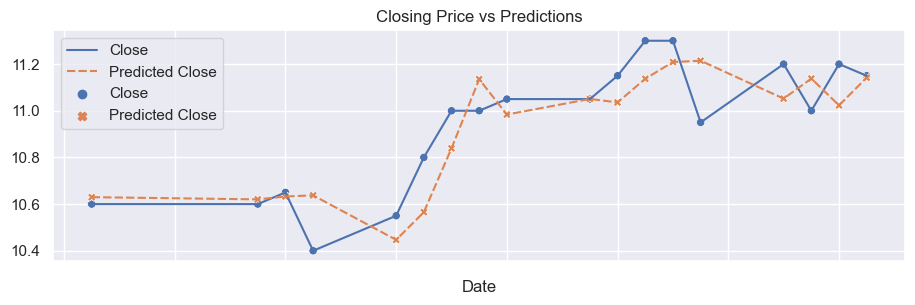

In [31]:
lstm_model_grid, lstm_model_grid_rmse, lstm_model_grid_mape = build_lstm_grid_search_model(main_df.copy(), with_fe=False)

# Save the model performance
df_performances['lstm_grid'] = [lstm_model_grid_rmse, lstm_model_grid_mape]

# Run 3

default models and feature engineering

## Feature Engineering - Creating Financial Indicators

In [32]:
def financial_indicators(main_df):

    import pandas_ta as ta

    # simple moving average
    sma = ta.sma(main_df["Close"], length=2)
    main_df['sma'] = sma

    # Weighted Moving Average: wma
    wma = ta.wma(main_df["Close"], length=2)
    main_df['wma'] = wma

    # Momemtum
    mom = ta.mom(main_df["Close"], length=2)
    main_df['mom'] = mom

    # stochastic ochilator
    stoch = ta.stoch(high = main_df["High"], low = main_df["Low"], close = main_df["Close"])
    main_df['stoch_k'] = stoch["STOCHk_14_3_3"]
    main_df['stoch_d'] = stoch["STOCHd_14_3_3"]

    # RSI
    rsi = ta.rsi(main_df["Close"], length=2)
    main_df['rsi'] = rsi

    # MACD
    macd = ta.macd(main_df["Close"])
    main_df['macd'] = macd['MACD_12_26_9']

    # William's R
    willr = ta.willr(high = main_df["High"], low = main_df["Low"], close = main_df["Close"], length=7)
    main_df['willr'] = willr

    # A/D (Accumulation/Distribution) Oscillator
    adosc = ta.adosc(high = main_df["High"], low = main_df["Low"], close = main_df["Close"], volume = main_df['Volume'])
    main_df['adosc'] = adosc

    # Commodity Channel Index: cci
    cci = ta.cci(high = main_df["High"], low = main_df["Low"], close = main_df["Close"])
    main_df['cci'] = cci

    main_df.dropna(inplace=True)

    return main_df

## XGBoost

RMSE: 0.18559572901291266
MAPE: 0.013772656603224494


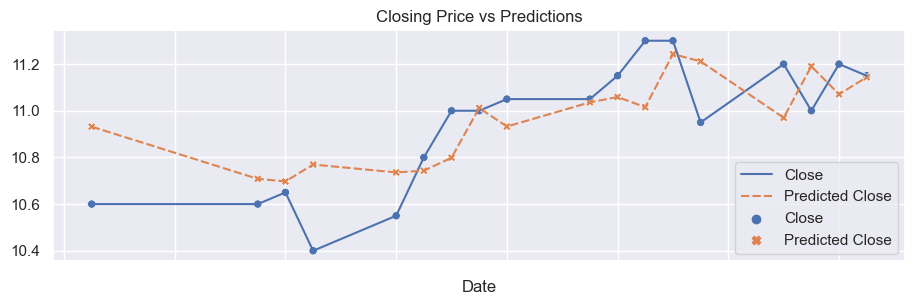

In [33]:
# build XGB model with lagged values and default parameters
xgb_model_fe, xgb_model_fe_rmse, xgb_model_fe_mape = build_xgboost_default_model(main_df.copy(), with_fe=True)


# Save the model performance
df_performances['xgb_fe_rmse'] = [xgb_model_fe_rmse, xgb_model_fe_mape]

## Random Forest

RMSE: 0.13894052035196247
MAPE: 0.009315866726346475


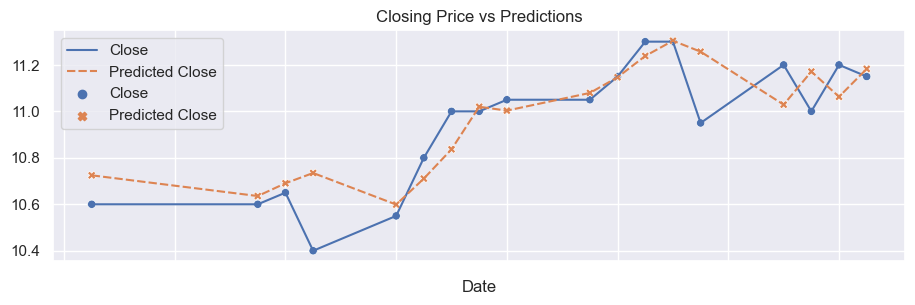

In [34]:
# Random Forest default model with default features
rf_model_fe, rf_model_fe_rmse, rf_model_fe_mape = build_random_forest_default_model(main_df.copy(), 
                                                                    with_fe = True)

# Save the model performance
df_performances['rf_fe'] = [rf_model_fe_rmse, rf_model_fe_mape]

## SVM

RMSE: 0.7587353710539495
MAPE: 0.06518244926930895


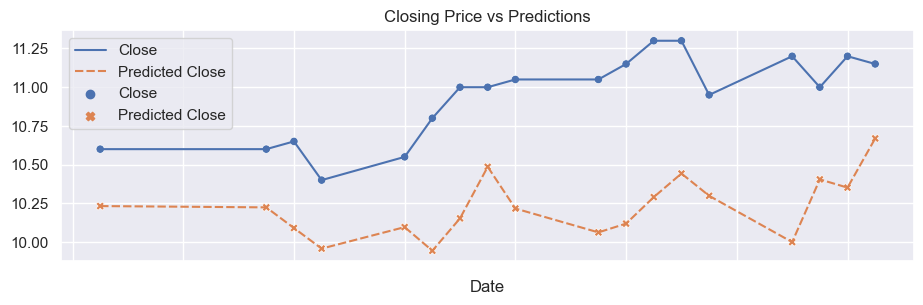

In [35]:
# build XGB model with lagged values and default parameters
svm_model_fe, svm_model_fe_rmse, svm_model_fe_mape = build_svm_default_model(main_df.copy(), with_fe=True)


# Save the model performance
df_performances['svm_fe'] = [svm_model_fe_rmse, svm_model_fe_mape]

## kNN

RMSE: 0.29805721875889396
MAPE: 0.022937103685063808


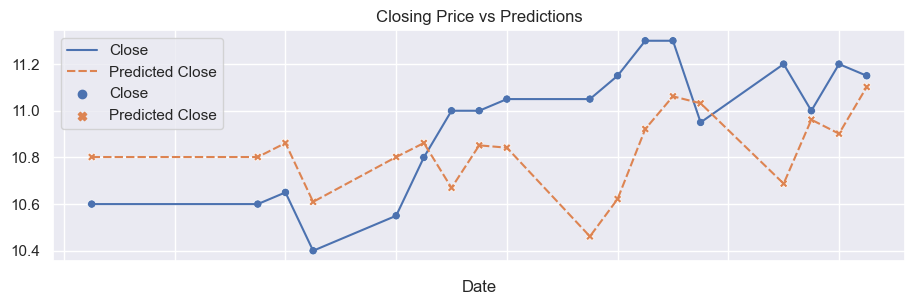

In [36]:
knn_model_fe, knn_model_fe_rmse, knn_model_fe_mape = build_knn_default_model(main_df.copy(), with_fe=True)

# # Save the model performance
df_performances['knn_fe'] = [knn_model_fe_rmse, knn_model_fe_mape]

## LSTM

Train on 1077 samples
Epoch 1/10
1077/1077 - 4s - loss: 0.7961
Epoch 2/10
1077/1077 - 1s - loss: 0.2505
Epoch 3/10
1077/1077 - 1s - loss: 0.0895
Epoch 4/10
1077/1077 - 1s - loss: 0.0571
Epoch 5/10
1077/1077 - 1s - loss: 0.0442
Epoch 6/10
1077/1077 - 1s - loss: 0.0353
Epoch 7/10
1077/1077 - 1s - loss: 0.0286
Epoch 8/10
1077/1077 - 1s - loss: 0.0229
Epoch 9/10
1077/1077 - 2s - loss: 0.0187
Epoch 10/10
1077/1077 - 2s - loss: 0.0160
RMSE: 0.44218948784570705
MAPE: 0.03625852301509479


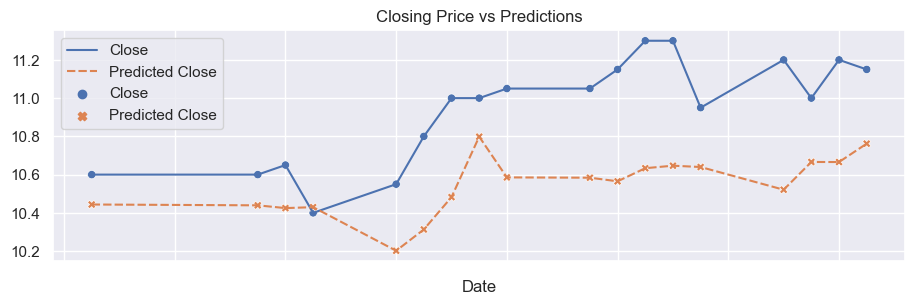

In [37]:
lstm_model_fe, lstm_model_fe_rmse, lstm_model_fe_mape = build_lstm_default_model(main_df.copy(), with_fe = True)

# Save the model performance
df_performances['lstm_fe'] = [lstm_model_fe_rmse, lstm_model_fe_mape]

# Run 4

Tuned models with feature engineering

## Random Forest

{'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100}
RMSE: 0.1451257125247961
MAPE: 0.010194677811957691


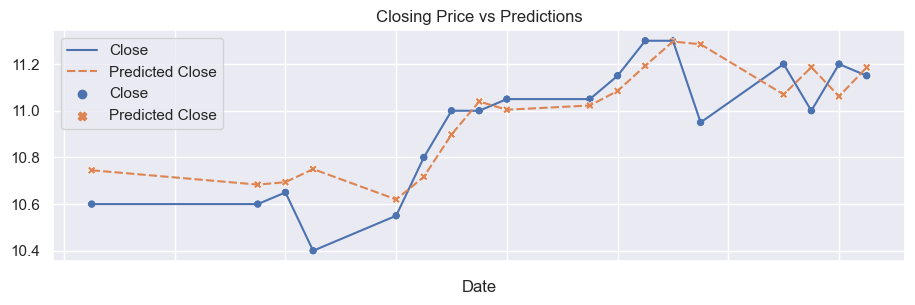

In [38]:
# Random Forest default model with default features
rf_model_grid_fe, rf_model_grid_fe_rmse, rf_model_grid_fe_mape = build_random_forest_grid_search_model(main_df.copy(), 
                                                                    with_fe = True)

# Save the model performance
df_performances['rf_grid_fe'] = [rf_model_grid_fe_rmse, rf_model_grid_fe_mape]

## XGBoost

{'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 100}
RMSE: 0.18274492492597252
MAPE: 0.01277346311768523


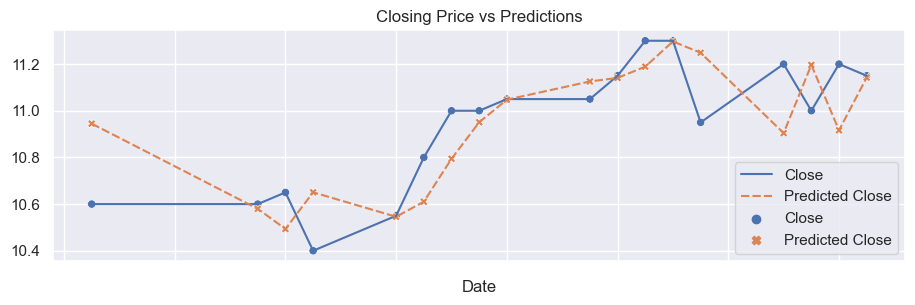

In [39]:
# Random Forest default model with feature engineering
xgb_model_grid_fe, xgb_model_grid_fe_rmse, xgb_model_grid_fe_mape = build_xgboost_grid_search_model(main_df.copy(), 
                                                                    with_fe = True)

# Save the model performance
df_performances['xgb_grid_fe'] = [xgb_model_grid_fe_rmse, xgb_model_grid_fe_mape]

## kNN

RMSE: 0.29805721875889396
MAPE: 0.022937103685063808


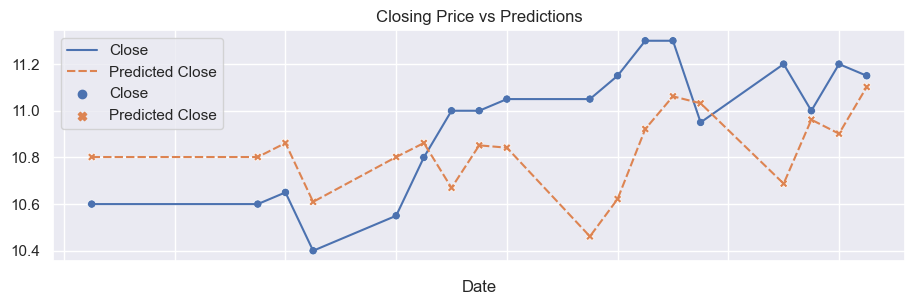

In [40]:
knn_model_grid_fe, knn_model_grid_fe_rmse, knn_model_grid_fe_mape = build_knn_default_model(main_df.copy(), with_fe=True)

# Save the model performance
df_performances['knn_grid_fe'] = [knn_model_grid_fe_rmse, knn_model_grid_fe_mape]

## SVM

RMSE: 0.7587353710539495
MAPE: 0.06518244926930895


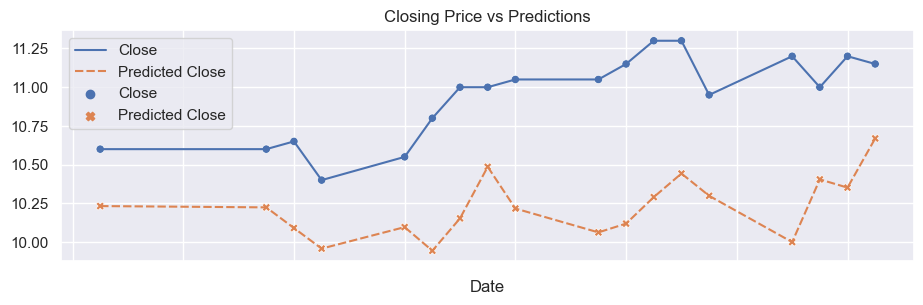

In [41]:
svm_model_grid_fe, svm_model_grid_fe_rmse, svm_model_grid_fe_mape = build_svm_default_model(main_df.copy(), with_fe=True)

# Save the model performance
df_performances['svm_grid_fe'] = [svm_model_grid_fe_rmse, svm_model_grid_fe_mape]

## LSTM

Train on 1077 samples
Epoch 1/20
1077/1077 - 4s - loss: 0.2408
Epoch 2/20
1077/1077 - 1s - loss: 0.0207
Epoch 3/20
1077/1077 - 1s - loss: 0.0118
Epoch 4/20
1077/1077 - 1s - loss: 0.0092
Epoch 5/20
1077/1077 - 1s - loss: 0.0082
Epoch 6/20
1077/1077 - 1s - loss: 0.0078
Epoch 7/20
1077/1077 - 1s - loss: 0.0074
Epoch 8/20
1077/1077 - 1s - loss: 0.0072
Epoch 9/20
1077/1077 - 1s - loss: 0.0071
Epoch 10/20
1077/1077 - 1s - loss: 0.0071
Epoch 11/20
1077/1077 - 1s - loss: 0.0070
Epoch 12/20
1077/1077 - 1s - loss: 0.0069
Epoch 13/20
1077/1077 - 1s - loss: 0.0067
Epoch 14/20
1077/1077 - 1s - loss: 0.0069
Epoch 15/20
1077/1077 - 1s - loss: 0.0066
Epoch 16/20
1077/1077 - 1s - loss: 0.0067
Epoch 17/20
1077/1077 - 1s - loss: 0.0065
Epoch 18/20
1077/1077 - 1s - loss: 0.0067
Epoch 19/20
1077/1077 - 1s - loss: 0.0063
Epoch 20/20
1077/1077 - 1s - loss: 0.0064
{'batch_size': 10, 'epochs': 20, 'optimizer': 'rmsprop', 'units': 30}
18/18 - 0s
RMSE: 0.24071352010851896
MAPE: 0.019175326364505904


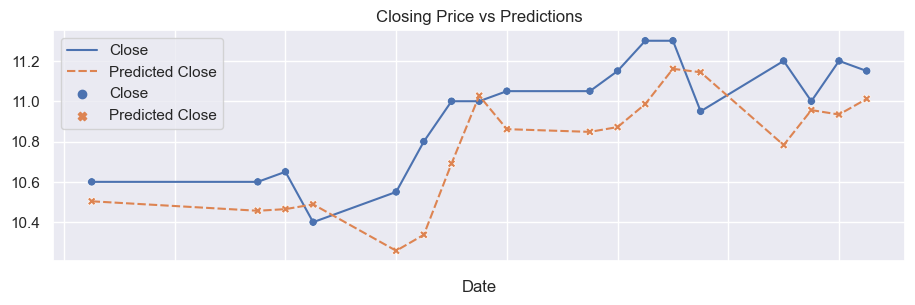

In [42]:
lstm_model_grid_fe, lstm_model_grid_fe_rmse, lstm_model_grid_fe_mape = build_lstm_grid_search_model(main_df.copy(), with_fe=True)

# Save the model performance
df_performances['lstm_grid_fe'] = [lstm_model_grid_fe_rmse, lstm_model_grid_fe_mape]

In [43]:
df_performances.transpose()

,rmse,mape
Arima,0.150457,0.010571
rf,0.133672,0.009768
xgb,0.200465,0.014438
svm,0.144565,0.010755
knn,0.181033,0.014192
lstm,0.233094,0.017614
rf_grid,0.141222,0.010959
xgb_grid,0.174309,0.012413
knn_grid,0.181033,0.014192
svm_grid,0.144565,0.010755


# Feature Importances

In [44]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

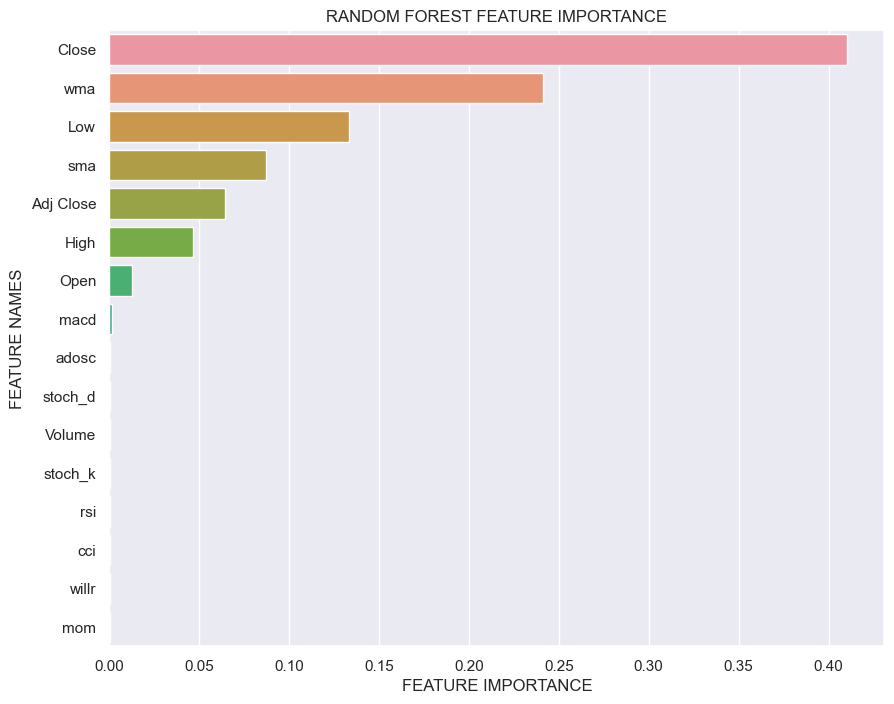

In [60]:
train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml(main_df.copy(), 
                                train_start = train_start_time,
                                train_end = train_end_time,
                                validation_start = validation_start_time,
                                validation_end = validation_end_time,
                                test_start = test_start_time,
                                test_end = test_end_time,
                                best_lag_period = 0,
                                with_fe = True,
                                is_diffed = False)


plot_feature_importance(rf_model_grid_fe.feature_importances_,train_and_validation_set.columns.drop("target"),'RANDOM FOREST')


# Future Experimentiments

In [61]:
def test(main_df):

    main_df['Open-Close'] = main_df['Open'] - main_df['Close']
    main_df['High-Close'] = main_df['High'] - main_df['Close']
    main_df['Low-Close'] = main_df['Low'] - main_df['Close']
    main_df['Target'] =  main_df['Close'].shift(-1) - main_df['Close']
    print(main_df)

In [62]:
def split_dataset_for_ml_diffed(main_df,
                        train_start = '2020-01-01',
                        train_end = '2022-12-31', 
                        validation_start = '2023-01-01',
                        validation_end = '2023-08-31',
                        test_start = '2023-09-01',
                        test_end = '2023-09-30'):
    
    # get initial columns from main_df
    columns = main_df.copy().columns

    
    # Prepare the closing price as target variable
    main_df['Return'] = main_df['Close'].pct_change()
    main_df['MA_5'] = main_df['Close'].rolling(window=5).mean()
    main_df['MA_10'] = main_df['Close'].rolling(window=10).mean()
    main_df['Volatility'] = main_df['Close'].rolling(window=5).std()
    main_df['Volume_Change'] = main_df['Volume'].pct_change()
    main_df['Price_Diff'] = main_df['Close'].diff()

    features = ['Return', 'MA_5', 'MA_10', 'Volatility', 'Volume_Change', 'Price_Diff']
    main_df = main_df[features]
            

    # Split the data into train, validation, and test sets
    train_set = main_df[(main_df.index >= train_start) & (main_df.index <= train_end)]
    validation_set = main_df[(main_df.index >= validation_start) & (main_df.index <= validation_end)]
    train_and_validation_set = pd.concat([train_set, validation_set], axis=0)

    test_set = main_df[(main_df.index >= test_start) & (main_df.index <= test_end)]
    test_set = test_set[:-1]    


    return train_set, validation_set, train_and_validation_set, test_set

In [63]:
train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml_diffed(main_df.copy(), 
                                train_start = train_start_time,
                                train_end = train_end_time,
                                validation_start = validation_start_time,
                                validation_end = validation_end_time,
                                test_start = test_start_time,
                                test_end = test_end_time)

main_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-06-27,1.404705,1.475293,1.355293,1.432940,1.023544,99085
2008-06-30,1.475293,1.489411,1.432940,1.447058,1.033629,7281
2008-07-01,1.496470,1.496470,1.390587,1.418823,1.013461,11477
2008-07-02,1.425882,1.425882,1.362352,1.390587,0.993292,24550
2008-07-03,1.362352,1.390587,1.341176,1.390587,0.993292,11428
...,...,...,...,...,...,...
2024-06-20,10.800000,10.800000,10.600000,10.700000,10.700000,17631
2024-06-21,10.650000,10.750000,10.600000,10.650000,10.650000,17911
2024-06-25,10.650000,10.950000,10.600000,10.950000,10.950000,10707


In [64]:
def build_random_forest_default_model_diff(main_df):

    from sklearn.ensemble import RandomForestRegressor
    
    train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml_diffed(main_df.copy(), 
                                train_start = train_start_time,
                                train_end = train_end_time,
                                validation_start = validation_start_time,
                                validation_end = validation_end_time,
                                test_start = test_start_time,
                                test_end = test_end_time)
    

    # Prepare the data for Random Forest
    X_train = train_and_validation_set.drop(['Price_Diff'], axis=1, inplace=False)
    y_train = train_and_validation_set['Price_Diff']

    X_test = test_set.drop(['Price_Diff'], axis=1, inplace=False)
    y_test = test_set['Price_Diff']
    
    
    # Train the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=4)
    model.fit(X_train, y_train)

    # Make predictions using the trained model
    predicted_diffs = model.predict(X_test)
    print(main_df['Close'].iloc[len(X_train)])
    last_close_price = main_df['Close'].iloc[len(X_train)]
    predicted_prices = [last_close_price + predicted_diffs[0]]

    for diff in predicted_diffs[1:]:
        next_price = predicted_prices[-1] + diff
        predicted_prices.append(next_price)
    
    print(predicted_prices)
    
    return model

In [65]:
build_random_forest_default_model_diff(main_df)

0.8999999761581421
[0.8023999118804932, 0.8023999118804932, 0.8023999118804932, 0.8520996284484864, 0.6146995639801026, 0.759000062942505, 1.006800036430359, 1.1713001155853273, 1.1713001155853273, 1.2212001419067384, 1.2212001419067384, 1.3206004428863527, 1.4575007629394534, 1.4575007629394534, 1.1383006954193118, 1.373000683784485, 1.1769008779525758, 1.3362009763717653]


RandomForestRegressor(n_jobs=4, random_state=42)